In [ ]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import pandas as pd
import numpy as np
import cv2  # conda install -c conda-forge opencv
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

#from utils import get_video_properties, get_contours_from_segmasks, get_contour_stats, rotate_masks_and_contours, rotate_masks_and_images, find_top_bottom_points_from_contours, export_selected_frames, normalize_contours_by_centers, shift_contours, autocorr_with_interpolation, transform_points_to_original_space
from utils.egocentric_utils import plot_colorline
from utils.utils import create_scalarmappable

# Feature extraction
from torch.utils.data import DataLoader
import torch
from torchvision import transforms
import torchvision
import timm
import umap

%matplotlib inline
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.grid"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["font.size"] = 15
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams['figure.facecolor'] = 'white'

# construct feature extraction df

In [2]:
#dataset_root_path = f"./data/images/resized_cropped_squarebbox_rgb_wbg_224/"
#ds = timm.data.create_dataset("folder", root=dataset_root_path)
# len(ds)

## FOR FEATURE EXTRACTION
- Try to rotate first and then save to disc > egocentric
- Cut a major square bbox around so that scale is accessible for algorithm

In [3]:
torch.set_grad_enabled(False)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
norm_tf = transforms.Normalize(mean=[0.5],  # maybe adjust this for each network?
                                        std=[0.5])

tfs = transforms.Compose([
    transforms.ToTensor(),
    norm_tf])

dataset_name = "resized_cropped_squarebbox_rgb_gbg_224"
root_path = f"./data/images/{dataset_name}/"  # 22214
#root_path = "./data/images/resized_cropped_squarebbox_gs_224/"  # 22214
ds = torchvision.datasets.ImageFolder(root=root_path)
ds.transform = tfs
print(ds, "\n", ds.classes)

dataloader = DataLoader(ds, batch_size=24, num_workers=6, shuffle=False)

labels_ = []
for _, labels in dataloader:
    labels_.append(labels.detach().cpu().numpy())

labels = np.concatenate(labels_)
df = pd.DataFrame(ds.classes)
df.iloc[14,:]

Dataset ImageFolder
    Number of datapoints: 14508
    Root location: ./data/images/resized_cropped_squarebbox_rgb_gbg_224/ 
 ['2024_0201_152845_091_10sec', '2024_0201_152845_091_subclip_7sec_ts98-te105_cropped', '2024_0216_094236_090_11sec_cropped', '2024_0216_161747_055_20sec_cropped', '2024_0311_152452_018_trimmed_15sec_ts0-te15_cropped_700-2100-400-1800', '2024_0311_153344_021_trimmed_10sec_ts28-te38_cropped_1050-1800-800-2000', '2024_0312_194950_050_trimmed', '2024_0312_200031_053_trimmed_15sec_ts74-te89_cropped_250-1250-0-1100', '2024_0322_170346_054_trimmed', '2024_0324_204541_027_trimmed', '2024_0328_094441_053_trimmed', '2024_0330_120233_097_trimmed', '2024_0330_120947_101_trimmed', '2024_0330_121516_105_trimmed', '2024_0330_122058_107_trimmed_ts6-te120', '2024_0331_091926_007_trimmed', '2024_0408_074310_021', '2024_0415_084257_008_trimmed', '2024_0512_085355_018_trimmed', '2024_0512_091209_023_trimmed']


0    2024_0330_122058_107_trimmed_ts6-te120
Name: 14, dtype: object

In [4]:
# Load feature vectors
feature_path = f"./data/results/features/{dataset_name}/"
feature_filenames = [f for f in os.listdir(feature_path) if f.endswith(".npy")]
print(feature_filenames)

# T-SNE Setup with equal parameters
tsne_params = {"n_components" : 2, "perplexity" : 60, "learning_rate" : 150, "n_iter" : 1000,
            "early_exaggeration" : 50, "random_state" : 42, "init" : "pca", "n_iter_without_progress" : 300}

PLOT_NETWORKS = False
if PLOT_NETWORKS:    
    fig, ax = plt.subplots(1,3, figsize=(12,4))  # plt.figure(figsize=(4,4))
    for ith, feature_filename in enumerate(feature_filenames):
        
        LOAD_FEATS = True
        if LOAD_FEATS:
            feature_vectors = np.load(os.path.join(feature_path, feature_filename))
            
        tsne = TSNE(**tsne_params);
        embed = tsne.fit_transform(feature_vectors);

        uexp = np.unique(labels); print(uexp)
        uidx = []  # indices of unique
        for uniq in uexp:
            uidx.append(np.where(labels == uniq)[0])

        # experiment color code
        cmap = plt.get_cmap("coolwarm")
        colors = [cmap(i)[:3] for i in np.linspace(0, 1, len(uexp))]
        
        # highlight color code
        hindices = np.where(labels == 14)[0]  # highlight
        hcmap = plt.get_cmap("jet")
        hcolors = [hcmap(i)[:3] for i in np.linspace(0, 1, len(hindices))]
        
        ax[ith].scatter(embed[hindices, 0], embed[hindices, 1], marker="o", s=6, edgecolors="None", c=hcolors, alpha=.55);
        for nth, idx in enumerate(uidx):
            ax[ith].scatter(embed[idx, 0], embed[idx, 1], marker="o", s=4, edgecolors="None", c=colors[nth], alpha=.85);

        ax[ith].set_title(feature_filename, fontsize=9) #plt.title("Experiment color-code");
        plt.axis("equal"); plt.tight_layout()
        ax[ith].set_xlabel("tSNE dim 1"); ax[ith].set_ylabel("tSNE dim 2");
        
    fig.savefig(f"./data/results/tSNE/three_networks_{dataset_name}_hindices.jpg", dpi=600)  # bbox inche?

['feature_vectors_eva02_base_patch14_224.mim_in22k.npy']


In [5]:
LOAD_FEATS = True
feature_vectors = np.load(os.path.join(feature_path, feature_filenames[0])) if LOAD_FEATS else feature_vectors #None
tsne = TSNE(**tsne_params)
embed = tsne.fit_transform(feature_vectors)  

print(embed.shape)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


(14508, 2)


# Load dataframe of all recordings

In [6]:
df_all = pd.read_csv(f"./data/results/egocentric_all_stats.csv")
print(df_all.groupby(by="exp")["img_fp"].first())

exp
0     ../data/images/2024_0201_152845_091_10sec/fram...
1     ../data/images/2024_0201_152845_091_subclip_7s...
2     ../data/images/2024_0216_094236_090_11sec_crop...
3     ../data/images/2024_0216_161747_055_20sec_crop...
4     ../data/images/2024_0311_152452_018_trimmed_15...
5     ../data/images/2024_0311_153344_021_trimmed_10...
6     ../data/images/2024_0312_194950_050_trimmed/fr...
7     ../data/images/2024_0312_200031_053_trimmed_15...
8     ../data/images/2024_0322_170346_054_trimmed/fr...
9     ../data/images/2024_0324_204541_027_trimmed/fr...
10    ../data/images/2024_0328_094441_053_trimmed/fr...
11    ../data/images/2024_0330_120233_097_trimmed/fr...
12    ../data/images/2024_0330_120947_101_trimmed/fr...
13    ../data/images/2024_0330_121516_105_trimmed/fr...
14    ../data/images/2024_0330_122058_107_trimmed_ts...
15    ../data/images/2024_0331_091926_007_trimmed/fr...
16    ../data/images/2024_0408_074310_021/frame_0000...
17    ../data/images/2024_0415_084257_008_tr

/var/folders/l1/s9h8bddx0mv1bqzrqffsxhp00000gn/T/ipykernel_15687/3613731931.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.axis("equal"); fig.tight_layout()


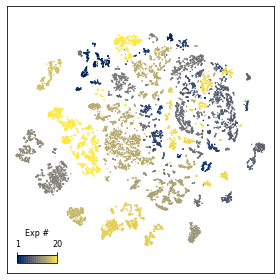

In [7]:
# Unique Experiments color code
uexp = df_all["exp"].unique()  # np.unique(labels)
uidx = [np.where(labels == uniq)[0] for uniq in uexp]
c, sm = create_scalarmappable("cividis", range(len(uexp)))

# Plot Without highlight
fig, ax = plt.subplots(1,1, figsize=(4,4))
for nth, idx in enumerate(uidx):
    sax = ax.scatter(embed[idx, 0], embed[idx, 1], marker="o", s=2, edgecolors="None", c=[c[nth]], alpha=.85)

# inset axes
axin = inset_axes(ax, width="15%", height="3%", loc="lower left", borderpad=1)
cbar = fig.colorbar(sm, cax=axin, orientation="horizontal", ticks=[0, 19], boundaries=np.arange(0,20))
cbar.set_label("Exp #", fontsize=8)  # Set label and its font size
cbar.set_ticklabels([1, 20], fontsize=8)  # Set tick labels and their font size

# Adjust tick and label positions
axin.xaxis.set_ticks_position("top")
axin.xaxis.set_label_position("top")

# General axes
ax.set(xticks=[], yticks=[], xlabel="", ylabel="");
ax.axis("equal"); fig.tight_layout()
for spine in ax.spines.values():
    spine.set_visible(True)

SAVE_FIGURES = False
fig.savefig(f"./data/results/tSNE/one_network_{dataset_name}_nohighlight_eva_vit.jpg", dpi=600, bbox_inches="tight") if SAVE_FIGURES else None

## exp 14 umap

In [23]:
embed_local = umap.UMAP().fit_transform(feature_vectors[uidx[14], :])
embed_global = umap.UMAP(n_neighbors=30).fit_transform(feature_vectors[uidx[14], :])

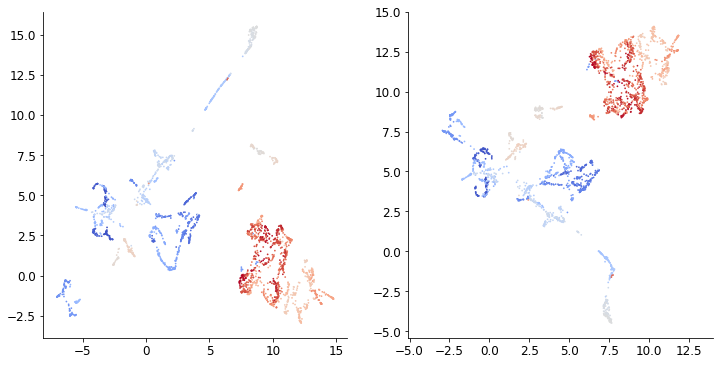

In [32]:

fig, ax = plt.subplots(1,2, figsize=(12,6))
for nth, embed in enumerate([embed_local, embed_global]):
    sax = ax[nth].scatter(embed[:, 0], embed[:, 1], marker="o", s=3, edgecolors="None", c=range(len(uidx[14])), alpha=1, cmap="coolwarm") # =[c[nth]], color="gray",
    plt.axis("equal");

In [50]:
#embedding = umap.UMAP(densmap=True).fit_transform(feature_vectors)
embed = umap.UMAP(n_neighbors=30).fit_transform(feature_vectors) # n_neighbours=30 more global structure
#embedding3 = umap.UMAP(metric="correlation").fit_transform(feature_vectors)
print(feature_vectors.shape, embed.shape)

(14508, 768) (14508, 2)


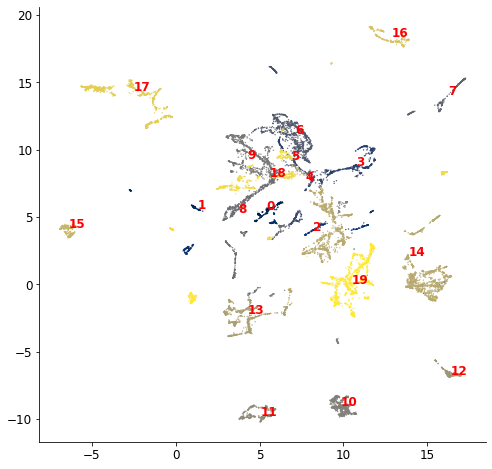

In [51]:
from matplotlib_scalebar.scalebar import ScaleBar

c, sm = create_scalarmappable("cividis", range(len(uexp)))
# fig, ax = plt.subplots(figsize=(8,8))
# for nth, idx in enumerate(uidx):
#     sax = ax.scatter(embedding3[idx, 0], embedding3[idx, 1], marker="o", s=2, edgecolors="None", c=[c[nth]], alpha=.85)
#     xtext, ytext = np.median(embedding3[idx, :], axis=0)
#     ax.text(xtext, ytext, str(nth), fontsize=12, color='red', fontweight="bold")
    
    
fig, ax = plt.subplots(figsize=(8,8))
for nth, idx in enumerate(uidx):
    sax = ax.scatter(embed[idx, 0], embed[idx, 1], marker="o", s=2, edgecolors="None", c=[c[nth]], alpha=.85)
    xtext, ytext = np.median(embed[idx, :], axis=0)
    ax.text(xtext, ytext, str(nth), fontsize=12, color='red', fontweight="bold")

# fig, ax = plt.subplots(figsize=(8,8))
# for nth, idx in enumerate(uidx):
#     sax = ax.scatter(embed[idx, 0], embed[idx, 1], marker="o", s=2, edgecolors="None", c=[c[nth]], alpha=.85)
#     xtext, ytext = np.median(embed[idx, :], axis=0)
#     ax.text(xtext, ytext, str(nth), fontsize=12, color='red', fontweight="bold")

# for l in np.unique(labels):
#     xtext, ytext = np.median(embedding[labels == l, :], axis=0)
#     ax.text(xtext, ytext, str(l), fontsize=12, color='red')
# ax.set(xlim=[-10, 30], ylim=[-10, 30])
# #plt.axis("square");
# scalebar = ScaleBar(0.08, "cm", location="lower left", length_fraction=0.25, label="UMAP1", scale_loc="none")
# scalebar2 = ScaleBar(0.08, "cm", location="lower right", length_fraction=0.25, label="UMAP2", scale_loc="none", rotation="vertical")
# #scalebar.scale_text = "umap"
# ax.add_artist(scalebar)
# ax.add_artist(scalebar2)


# fig, ax = plt.subplots(figsize=(8,8))
# ax.scatter(embedding2[:, 0], embedding2[:, 1], c=labels, cmap="vanimo", s=5)
# for l in np.unique(labels):
#     xtext, ytext = np.median(embedding2[labels == l, :], axis=0)
#     ax.text(xtext, ytext, str(l), fontsize=12, color='red')
# #ax.set(xlim=[-10, 30], ylim=[-10, 30])
# plt.axis("square");



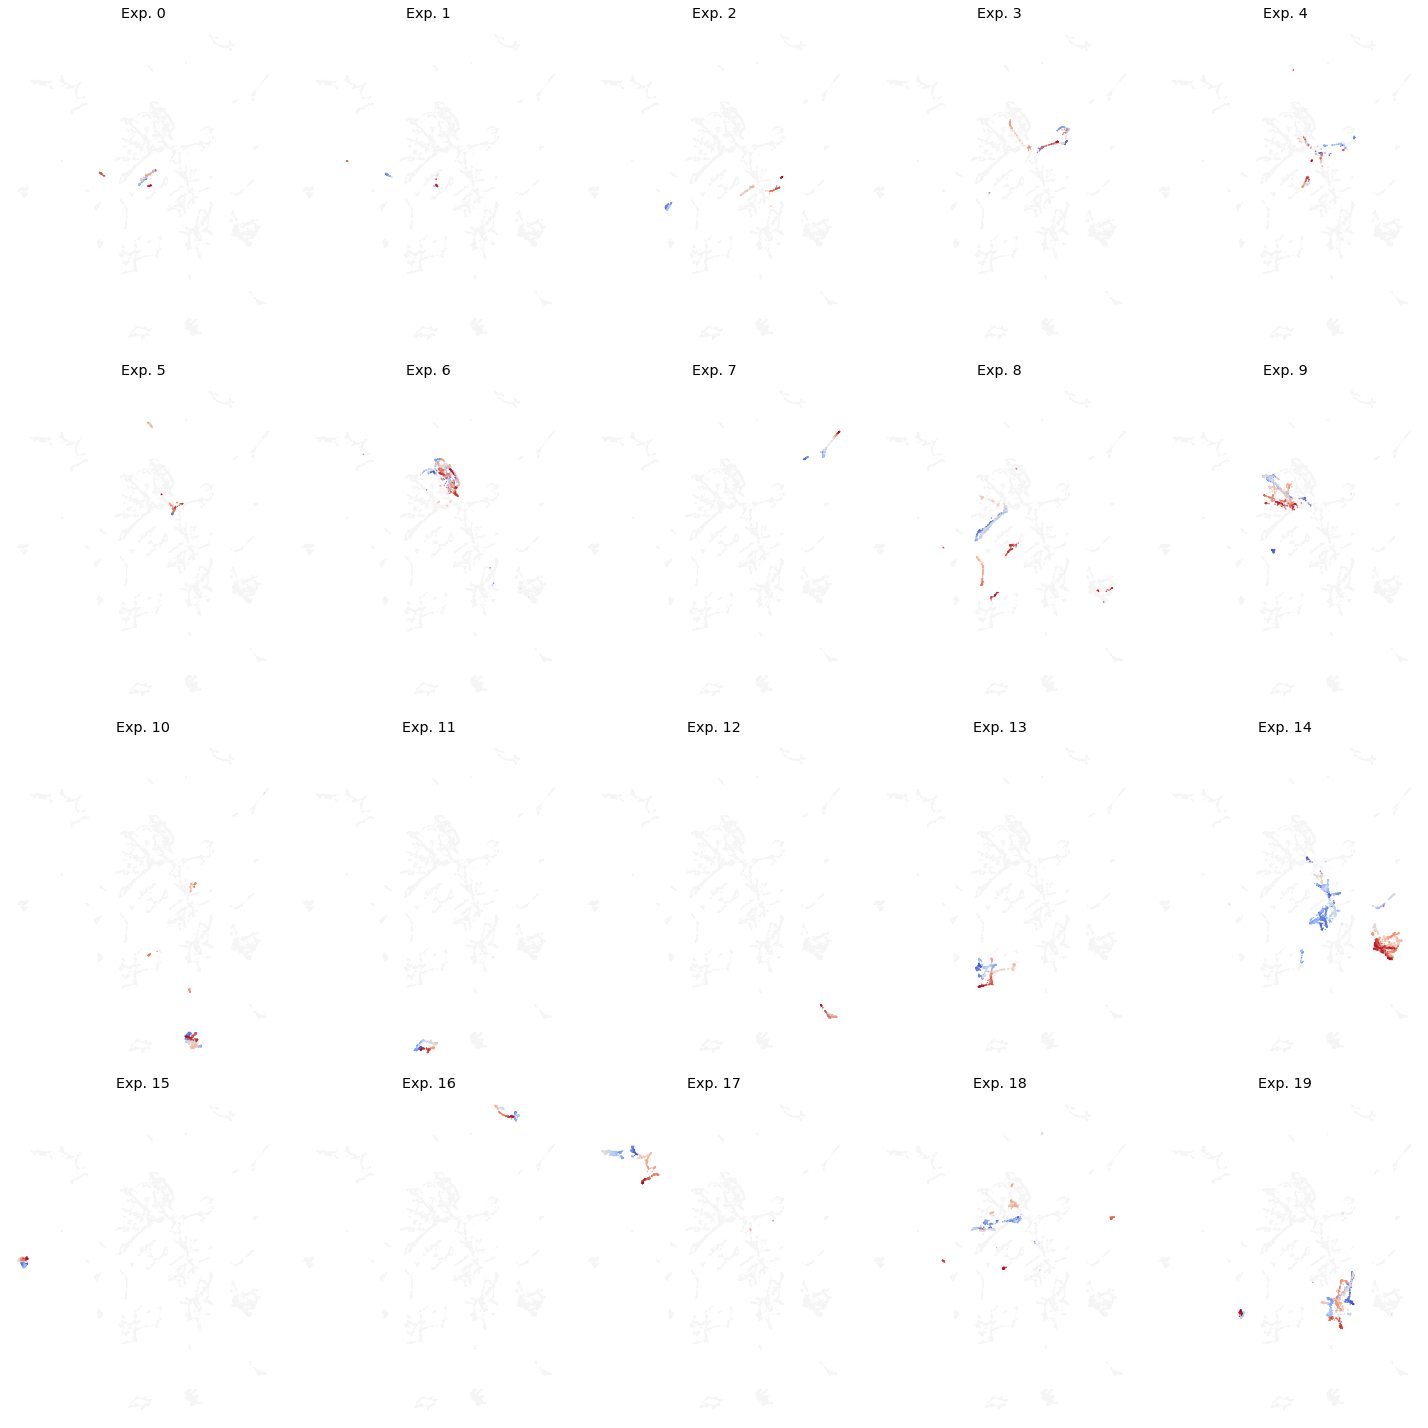

In [52]:
# Plot Without highlight
fig, ax = plt.subplots(4,5, figsize=(20,20), layout="tight")
ax = ax.flatten()

for nth, idx in enumerate(uidx):
    c_, _ = create_scalarmappable("coolwarm", range(len(idx)))
    ax[nth].scatter(embed[:, 0], embed[:, 1], marker="o", s=1, edgecolors="None", c="whitesmoke", alpha=1)
    ax[nth].scatter(embed[idx, 0], embed[idx, 1], marker="o", s=2, edgecolors="None", c=c_, alpha=.85)
    ax[nth].set_title(f"Exp. {nth}")
    ax[nth].axis("equal"); ax[nth].set_axis_off()
    for spine in ax[nth].spines.values():
        spine.set_visible(True)

fig.savefig(f"./data/results/tSNE/one_networks_{dataset_name}_allEXP-individuaually_eva_vit.jpg", dpi=600, bbox_inches="tight") if SAVE_FIGURES else None

# Highlight EXP14, 107 recording

/var/folders/l1/s9h8bddx0mv1bqzrqffsxhp00000gn/T/ipykernel_15687/1913928479.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.axis("equal"); fig.tight_layout(); ax.set_axis_off()


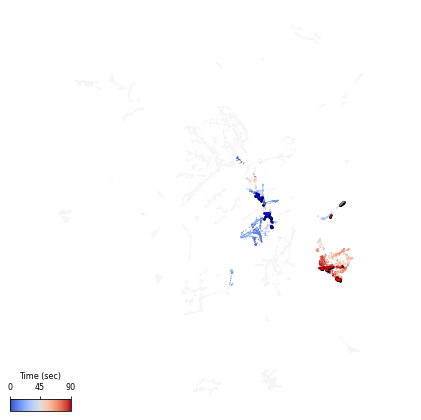

In [53]:
exp_nth = 14
df_cexp = df_all[df_all["exp"] == exp_nth]  # 107
exp_idx = df_cexp.index.values
expc, _ = create_scalarmappable("coolwarm", range(len(exp_idx)))  # , vminmax=(0, 90)

time = df_cexp.indices.values / 60
twindows = {"leech" : (31.6, 34.5), "stance" : (42, 44.25), "swim" : (87.5, 89.5)}

embed_idx = []
for k, v in twindows.items():
    selected_indices = np.where((time > v[0]) & (time <= v[1]))[0]
    bool_idx = df_cexp.indices.isin(selected_indices * 2)
    embed_idx.append(df_cexp[bool_idx].index.values)

cvec = ["b", "gray", "r"]
fig, ax = plt.subplots(1,1, figsize=(6,6)) # figsize=(3,3)
ax.scatter(embed[:, 0], embed[:, 1], marker="o", s=1, edgecolors="None", c="whitesmoke", alpha=1)
sax = ax.scatter(embed[exp_idx, 0], embed[exp_idx, 1], marker="o", s=1.5, edgecolors="None", c=expc, alpha=1)

for c, idx in zip(cvec, embed_idx):
    ax.scatter(embed[idx, 0], embed[idx, 1], marker="o", s=2.5, edgecolors="k", c=c, alpha=1)
    ax.scatter(embed[idx, 0], embed[idx, 1], marker="o", s=2, edgecolors="None", c=c, alpha=1)

axin = inset_axes(ax, width="15%", height="3%", loc="lower left", borderpad=.15)

# Create colorbar
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=plt.Normalize(vmin=0, vmax=90))
cbar = fig.colorbar(sm, cax=axin, orientation="horizontal", ticks=[0, 45, 90])
cbar.set_label("Time (sec)", fontsize=8)  # Set label and its font size
cbar.set_ticklabels([0, 45, 90], fontsize=8)  # Set tick labels and their font size

# Adjust tick and label positions
axin.xaxis.set_ticks_position("top")
axin.xaxis.set_label_position("top")

ax.set(xticks=[], yticks=[], xlabel="", ylabel="");
ax.axis("equal"); fig.tight_layout(); ax.set_axis_off()
fig.savefig(f"./data/results/tSNE/tSNE_{dataset_name}_highlight_exp{exp_nth}_eva_vit_axoff_.jpg", dpi=600, bbox_inches="tight") if SAVE_FIGURES else None

# Highlight EXP15, 007 recording

Highlight maybe one more recording > swimming with centroid change, maybe put this and 007 together when higlighting:
a) no centroid change, no peri change, b) centroid change, no peri change

/var/folders/l1/s9h8bddx0mv1bqzrqffsxhp00000gn/T/ipykernel_15687/873184614.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.axis("equal"); fig.tight_layout(); ax.set_axis_off()


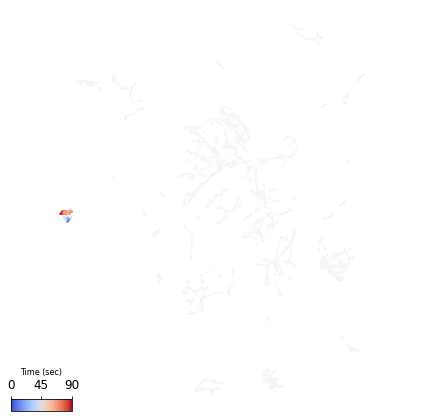

In [54]:
exp_nth = 15
df_cexp = df_all[df_all["exp"] == exp_nth]  # 107
exp_idx = df_cexp.index.values
expc, _ = create_scalarmappable("coolwarm", df_cexp.orientation) #range(len(exp_idx)))  # , vminmax=(0, 90)

cvec = ["b", "gray", "r"]
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.scatter(embed[:, 0], embed[:, 1], marker="o", s=1, edgecolors="None", c="whitesmoke", alpha=1)
sax = ax.scatter(embed[exp_idx, 0], embed[exp_idx, 1], marker="o", s=1.5, edgecolors="None", c=expc, alpha=.95)

axin = inset_axes(ax, width="15%", height="3%", loc="lower left", borderpad=.15)

# Create colorbar
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=plt.Normalize(vmin=0, vmax=90))
cbar = fig.colorbar(sm, cax=axin, orientation="horizontal", ticks=[0, 45, 90])
cbar.set_label("Time (sec)", fontsize=8)  # Set label and its font size
#cbar.set_ticklabels([0, 45, 90], fontsize=8)  # Set tick labels and their font size

# Adjust tick and label positions
axin.xaxis.set_ticks_position("top")
axin.xaxis.set_label_position("top")

ax.set(xticks=[], yticks=[], xlabel="", ylabel="");
ax.axis("equal"); fig.tight_layout(); ax.set_axis_off()
fig.savefig(f"./data/results/tSNE/tSNE_{dataset_name}_highlight_exp{exp_nth}_eva_vit_axoff_.jpg", dpi=600, bbox_inches="tight") if SAVE_FIGURES else None

# Highlight Habitat

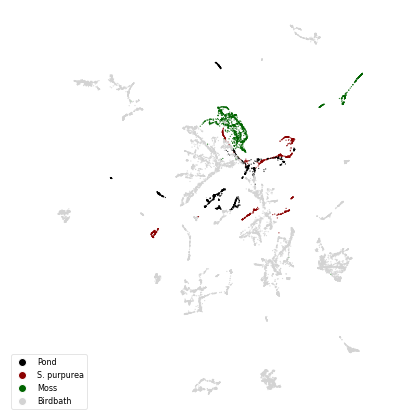

In [55]:
# Map recording to habitat
df_ = pd.DataFrame(ds.classes)
habitat = {0 : "Pond", 1 : "Pond", 2 : "S. purpurea", 3 : "S. purpurea",
           4 : "Pond", 5 : "Pond", 6 : "Moss", 7 : "Moss",  # 4-5 and 6-7 bot. garten but unclear from pond, moss or spring
           8 : "Birdbath", 9 : "Birdbath", 10 : "Birdbath", 11 : "Birdbath", 12 : "Birdbath", 13 : "Birdbath", 14 : "Birdbath", 15 : "Birdbath",
           16 : "Birdbath", 17 : "Birdbath", 18 : "Birdbath", 19 : "Birdbath"}

habi = pd.DataFrame.from_dict(habitat, orient="index", columns=["habitat"])
df_ = pd.concat((df_, habi), axis=1)

# Assign colors manually
habi_colors = {"Birdbath" : "lightgray", "Pond" : "k", "Moss" : "darkgreen", "S. purpurea" : "darkred"}  # "darkblue"
df_["colors"] = df_["habitat"]
habicolors = df_["colors"].replace(habi_colors)
habicolors = list(habicolors)

# Habitat Plot
fig, ax = plt.subplots(1,1, figsize=(6,6))
for nth, (idx, ccolor) in enumerate(zip(uidx, habicolors)):
    ax.scatter(embed[idx, 0], embed[idx, 1], marker="o", s=1.5, edgecolors="None", c=ccolor, alpha=.85)

ax.set(xticks=[], yticks=[], xlabel="", ylabel="");
ax.axis("equal"); fig.tight_layout(); ax.set_axis_off()

# legend
unique_habitats = df_["habitat"].unique()
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=habi_colors[hab], markersize=8, label=hab) for hab in unique_habitats]
ax.legend(handles=legend_handles, loc='lower left', fontsize=8, framealpha=.5)

fig.savefig(f"./data/results/tSNE/one_networks_{dataset_name}_eva_vit_habitat_.jpg", dpi=600, bbox_inches="tight") if SAVE_FIGURES else None

## Paramters on tSNE

In [62]:
# df_all = pd.read_csv(f"./data/results/egocentric_all_stats.csv")

# def filter_outliers(group):
#     std = group["centroid_dist"].std(ddof=0)
#     mean = group["centroid_dist"].mean()
#     filtered = group["centroid_dist"].where(group["centroid_dist"] <= mean + 5 * std, other=mean + 5 * std)
#     return filtered

# df_all["centroid_dist"].fillna(0, inplace=True)
# # Apply the filter to create a new column with the filtered values
# df_all["filtered_centroid_dist"] = df_all.groupby("exp").apply(filter_outliers).reset_index(level=0, drop=True)

# # Group by "exp" and apply z-score normalization on the filtered values
# df_all["zscored_centroid_dist"] = df_all.groupby("exp")["filtered_centroid_dist"].transform(
#     lambda x: (x - x.mean()) / x.std(ddof=0)
# )

/var/folders/l1/s9h8bddx0mv1bqzrqffsxhp00000gn/T/ipykernel_15687/3739835928.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_all["centroid_dist"].fillna(0, inplace=True)
/var/folders/l1/s9h8bddx0mv1bqzrqffsxhp00000gn/T/ipykernel_15687/3739835928.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly s

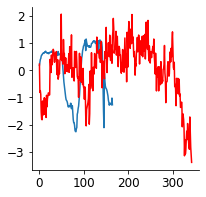

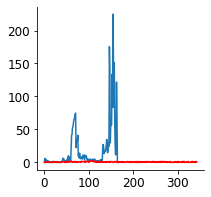

In [63]:
# NEED FOR PROPER NORMALIZATION OF CM_DIST BY MPP and FPS
idx = df_all["exp"].between(1,1)  # 8,8 but too much movement!
peri, cd = df_all.loc[idx, ["peri_zscore", "centroid_dist"]].T.values
idx2 = df_all["exp"].between(15,15)
peri2, cd2 = df_all.loc[idx2, ["peri_zscore", "centroid_dist"]].T.values

plt.figure(figsize=(3,3))
plt.plot(peri); plt.plot(peri2, "-r")
plt.figure(figsize=(3,3))
plt.plot(cd); plt.plot(cd2, "-r")

- problem here is > STAGE MOVEMENTS ARE STILL THERE!

0.0 30.0 [ 0.          1.21212121  4.99770379 14.02630876]


/var/folders/l1/s9h8bddx0mv1bqzrqffsxhp00000gn/T/ipykernel_15687/2228358658.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.axis("equal"); fig.tight_layout(); ax.set_axis_off()


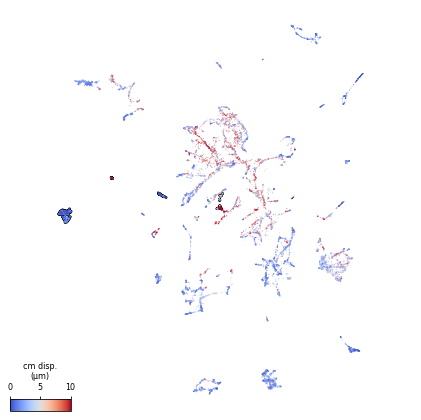

In [58]:
dfn = pd.read_csv(f"./data/results/egocentric_all_stats_normalized.csv")
# def filter_outliers(group):
#     std = group["ncentroid_dist"].std(ddof=0)
#     mean = group["ncentroid_dist"].mean()
#     filtered = group["ncentroid_dist"].where(group["ncentroid_dist"] <= mean + 5 * std, other=mean + 5 * std)
#     return filtered

# dfn["ncentroid_dist"].fillna(0, inplace=True)
# # Apply the filter to create a new column with the filtered values
# dfn["ncentroid_dist"] = dfn.groupby("exp").apply(filter_outliers).reset_index(level=0, drop=True)

# # Group by "exp" and apply z-score normalization on the filtered values
# dfn["ncentroid_dist"] = dfn.groupby("exp")["ncentroid_dist"].transform(lambda x: (x - x.mean()) / x.std(ddof=0))

var_name = "ncentroid_dist"
upper_clip = 30
var = dfn[var_name].fillna(0).clip(lower=0, upper=upper_clip)

print(vmin:=var.min(), vmax:=var.max(), np.percentile(var, [5,25, 75,95]))
ccmap = "coolwarm"
c, smap = create_scalarmappable(ccmap, var, vminmax=(0, 10))  # ,, vminmax=(0, .7)

fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.scatter(embed[:, 0], embed[:, 1], marker="o", s=1, edgecolors="None", c=c, alpha=.55)
ax.scatter(embed[idx, 0], embed[idx, 1], marker="o", s=3, edgecolors="k", c=c[idx], alpha=1)
ax.scatter(embed[idx, 0], embed[idx, 1], marker="o", s=2.5, edgecolors="None", c=c[idx], alpha=1)
ax.scatter(embed[idx2, 0], embed[idx2, 1], marker="o", s=3, edgecolors="k", c=c[idx2], alpha=1)
ax.scatter(embed[idx2, 0], embed[idx2, 1], marker="o", s=2.5, edgecolors="None", c=c[idx2], alpha=1)

axin = inset_axes(ax, width="15%", height="3%", loc="lower left", borderpad=.15)

cbar = fig.colorbar(smap, cax=axin, orientation="horizontal", ticks=[0, 5, 10])
cbar.set_label("cm disp.\n(µm)", fontsize=8)
cbar.set_ticklabels([0, 5, 10], fontsize=8) # 
axin.xaxis.set_ticks_position("top")
axin.xaxis.set_label_position("top")
ax.set(xticks=[], yticks=[], xlabel="", ylabel="");
ax.axis("equal"); fig.tight_layout(); ax.set_axis_off()
fig.savefig(f"./data/results/tSNE/tSNE_{dataset_name}_eva_vit_variable-color-coded-{var_name}_cmap-{ccmap}_hihglighted_EXP1_EXP15.jpg", dpi=600, bbox_inches="tight") if SAVE_FIGURES else None

208.60054962562796 1109.2967060565948 [310.57777604 452.06002935 687.29022178 850.94664116]


/var/folders/l1/s9h8bddx0mv1bqzrqffsxhp00000gn/T/ipykernel_15687/2798907802.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.axis("equal"); fig.tight_layout(); ax.set_axis_off()


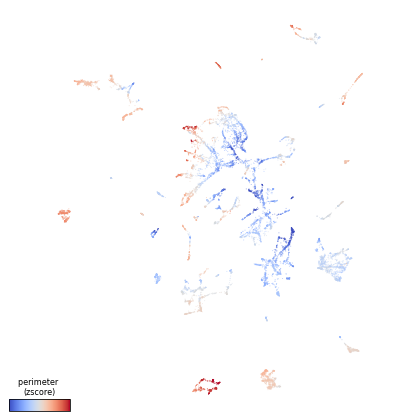

In [59]:
dfn["zscored_nperimeter"] = dfn.groupby("exp")["nperimeter"].transform(lambda x: (x - x.mean()) / x.std(ddof=0))
var_name = "nperimeter" # "zscored_nperimeter"#nperimeter! ie//mpp # "centroid_dist"
var = dfn[var_name].to_numpy()
print(vmin:=var.min(), vmax:=var.max(), np.percentile(var, [5,25, 75,95]))
ccmap = "coolwarm"
c, smap = create_scalarmappable(ccmap, var, vminmax=(250,970))#

fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.scatter(embed[:, 0], embed[:, 1], marker="o", s=1, edgecolors="None", c=c, alpha=.55)
axin = inset_axes(ax, width="15%", height="3%", loc="lower left", borderpad=.15)

cbar = fig.colorbar(smap, cax=axin, orientation="horizontal", ticks=[-3, 0, 3])
cbar.set_label("perimeter \n(zscore)", fontsize=8)
cbar.set_ticklabels([-3, 0, 3], fontsize=8) # 
axin.xaxis.set_ticks_position("top")
axin.xaxis.set_label_position("top")
ax.set(xticks=[], yticks=[], xlabel="", ylabel="");
ax.axis("equal"); fig.tight_layout(); ax.set_axis_off()
fig.savefig(f"./data/results/tSNE/tSNE_{dataset_name}_eva_vit_variable-color-coded-{var_name}_cmap-{ccmap}.jpg", dpi=600, bbox_inches="tight") if SAVE_FIGURES else None

# Clustering in tSNE space
- try out density based clustering pydbc

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


/var/folders/l1/s9h8bddx0mv1bqzrqffsxhp00000gn/T/ipykernel_15687/992119758.py:14: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(embed[idx, 0], embed[idx, 1], marker="o", s=6, edgecolors="None", c=clust_colors[nth], alpha=.85)


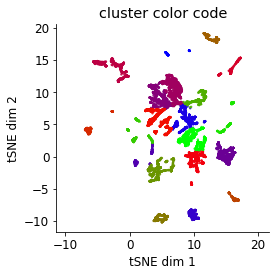

In [60]:
# Clustering
n_clusters = 20
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
kmeans.fit(embed)
clusters = kmeans.labels_
unique_cluster_labels = np.unique(clusters); print(unique_cluster_labels)

clust_cmap = plt.get_cmap("brg")
clust_colors = [clust_cmap(i)[:3] for i in np.linspace(0, 1, len(unique_cluster_labels))]

fig = plt.figure(figsize=(4,4)) 
for nth, cluster in enumerate(unique_cluster_labels):
    idx = clusters == cluster
    plt.scatter(embed[idx, 0], embed[idx, 1], marker="o", s=6, edgecolors="None", c=clust_colors[nth], alpha=.85)

plt.title("cluster color code"); plt.axis("equal")
plt.xlabel("tSNE dim 1"); plt.ylabel("tSNE dim 2"); plt.tight_layout()
#fig.savefig(f"./data/results/tSNE/three_networks_rgb_244_hindices_eva_vit_Nclusters{n_clusters}.jpg", dpi=600)  # bbox inche?

In [ ]:
# cluster_indices = {nth : np.where(clusters == cluster)[0] for nth, cluster in enumerate(unique_cluster_labels)}
# cluster_indices[3] = cluster_indices[3][:-7]  # correct for indices above 22214 for RGB only?

# tfs = transforms.Compose([transforms.ToTensor()])
# ds.transform = tfs

# for k, v in cluster_indices.items():
#     l = list()
#     for nth in v:
#         l.append(ds.__getitem__(nth)[0])
#     slist = torch.stack(l)
#     torchvision.utils.save_image(slist, fp=f"./data/results/tSNE/resized_rgb_224_individual_cluster_{k}.jpg", nrow=40)